In [2]:
!pip install deepxde

In [3]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



## Parâmetros

In [4]:
# Geometria e tempo
WIDTH = LENGTH = 10
T_END = 2 * np.pi

# Taxa de difusão
k = k = tf.constant(10 ** -8)

In [5]:
#Pontos de amostragem
SAMPLE_POINTS = 3000

#Rede Neural
ARCHITECTURE = (
    [3] + [60] * 9 + [1]
)
ACTIVATION = "Swish"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 1e-3
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 32

# Pesos dos componentes da função de perda (!!!)
LOSS_WEIGHTS = [
    10, #pde
    0.1,
    0.1,
    0.1,
    0.1, #up
    5, #ic
]

## Geometria

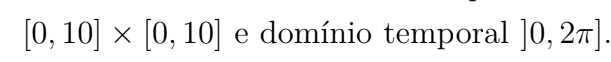

In [6]:
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])
timedomain = dde.geometry.TimeDomain(0, T_END)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Equação Diferencial

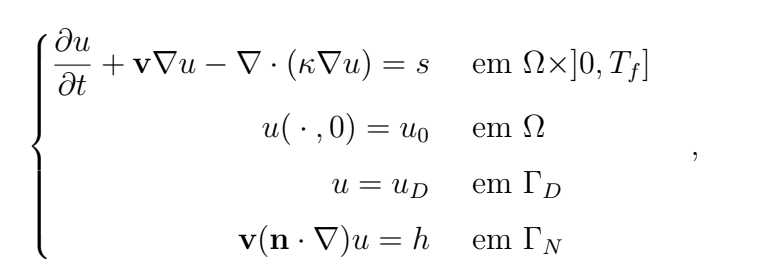

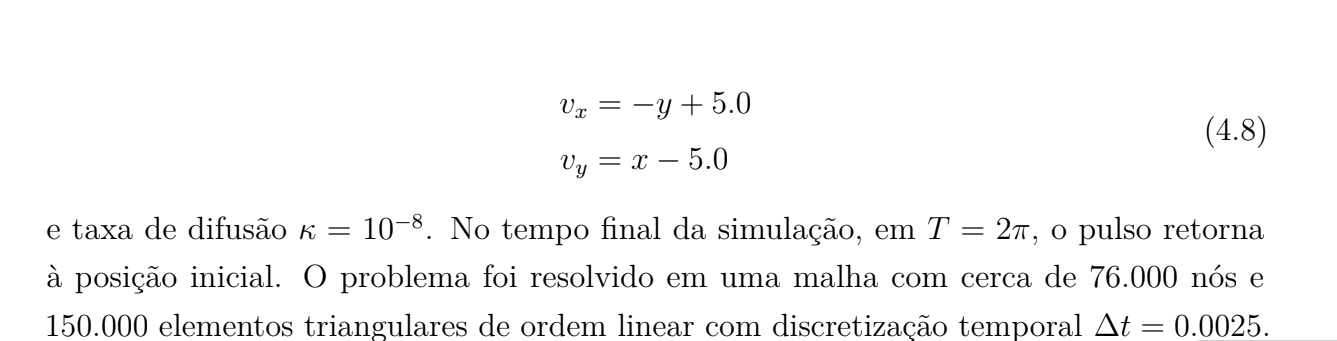

In [7]:
# u(x, y, t)

# i = 0 => x
# i = 1 => y
# i = 2 => t

## x[:, 0:1] => x
## x[:, 1:2]) => y
## x[:, 2:]) => t

def pde(X, U):
    dU_x = dde.grad.jacobian(U, X, j=0)
    dU_y = dde.grad.jacobian(U, X, j=1)
    dU_t = dde.grad.jacobian(U, X, j=2)

    dU_xx = dde.grad.hessian(U, X, i=0, j=0)
    dU_yy = dde.grad.hessian(U, X, i=1, j=1)

    return dU_t + (5 - X[:, 1:2]) * dU_x + (X[:, 0:1] - 5) * dU_y - k * (dU_xx + dU_yy)

## Condições da EDO

### Condição Inicial

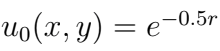

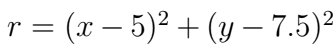

In [8]:
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

#Vetor para descrever o retorno da função com base em e^(-0.5 * r)
def func(x):
    r = np.power(x[:, 0:1] - 5, 2) + np.power(x[:, 1:2] - 7.5, 2)
    return np.exp(-0.5 * r)

### Condições de Dirichlet

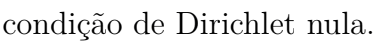

In [9]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

#Vetor de zeros para descrever o retorno da função
def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

In [10]:
bc_l = dde.DirichletBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.DirichletBC(geomtime, func_zero, boundary_top)
bc_low = dde.DirichletBC(geomtime, func_zero, boundary_bottom)

ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

## Dados que serão usados na PDE

In [11]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_low, bc_up, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

## Rede Neural

In [12]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)

model = dde.Model(data, net)
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.274889 s

'compile' took 8.552151 s



In [13]:
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.98e-04, 2.31e-06, 4.11e-05, 2.73e-06, 3.32e-05, 1.63e-01]    [4.98e-04, 2.31e-06, 4.11e-05, 2.73e-06, 3.32e-05, 1.63e-01]    []  
1000      [2.21e-03, 2.23e-05, 1.66e-05, 1.52e-05, 2.12e-05, 6.52e-05]    [2.21e-03, 2.23e-05, 1.66e-05, 1.52e-05, 2.12e-05, 6.52e-05]    []  
2000      [1.13e-03, 5.46e-06, 3.57e-06, 5.73e-06, 4.09e-06, 1.21e-04]    [1.13e-03, 5.46e-06, 3.57e-06, 5.73e-06, 4.09e-06, 1.21e-04]    []  
3000      [5.77e-04, 1.82e-06, 2.86e-06, 3.18e-06, 4.00e-06, 5.80e-05]    [5.77e-04, 1.82e-06, 2.86e-06, 3.18e-06, 4.00e-06, 5.80e-05]    []  
4000      [6.05e-05, 1.68e-06, 1.63e-06, 2.39e-06, 2.88e-06, 5.61e-06]    [6.05e-05, 1.68e-06, 1.63e-06, 2.39e-06, 2.88e-06, 5.61e-06]    []  
5000      [6.37e-05, 1.87e-06, 2.44e-06, 2.91e-06, 3.46e-06, 4.73e-06]    [6.37e-05, 1.87e-06, 2.44e-06, 2.91e-06, 3

In [14]:
# model.compile("L-BFGS-B", loss_weights=LOSS_WEIGHTS)
# losshistory, train_state = model.train(batch_size=BATCH_SIZE)

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


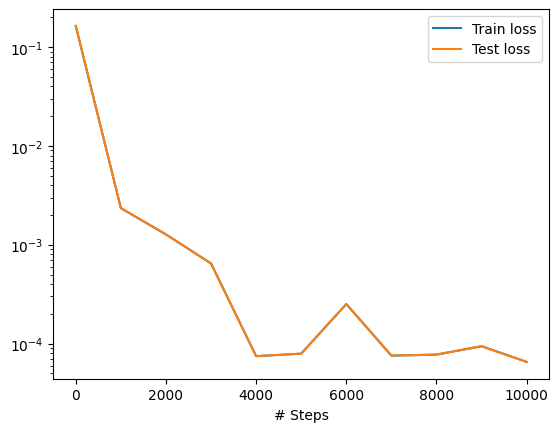

In [15]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_gaussian_pulse")
plt.close()

## Predição e Animação

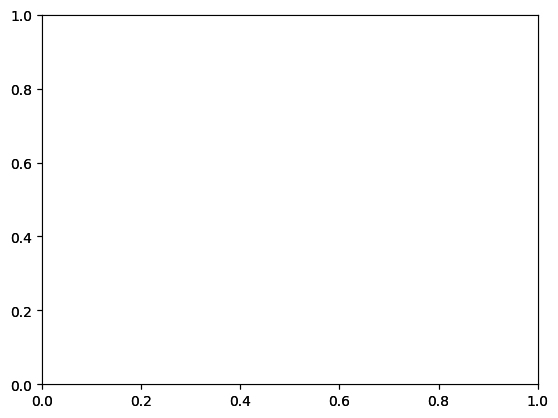

In [16]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

nelx = 100  # Número de elementos em x
nely = 100  # Número de elementos em y
timesteps = 401

x = np.linspace(0, WIDTH, nelx + 1)
y = np.linspace(0, LENGTH, nely + 1)
t = np.linspace(0, T_END, timesteps)

# Dados pra serem usados na predição
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [17]:
# Predição da solução
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)

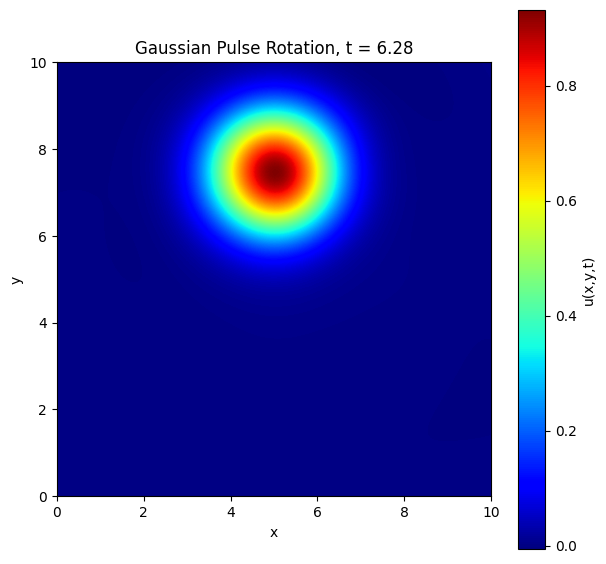

In [18]:
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Cria a imagem inicial com a barra de cores
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, WIDTH, 0, LENGTH],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Atualiza os frames
    def updatefig(k):
        # Atualiza a imagem em si
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Atualiza também as cores limitantes

        cb.update_normal(im)

        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


animate_solution(
    predicted_solution,
    f"gaussian_pulse_rotation.mp4",
    "Gaussian Pulse Rotation",
    "u(x,y,t)",
    t,
)

## Plot Gráfico Comparação com Artigo

In [19]:
num_values = 100
x = np.ones((num_values, 1)) * 5
y = np.linspace(0, 10, num_values).reshape(-1, 1)
t = np.ones((num_values, 1)) * (2 * np.pi)

input_data = np.hstack((x, y, t))

predicted_solution = np.empty((num_values, 1))
for i in range(num_values):
    predicted_solution[i] = model.predict(input_data[i].reshape(1, -1))

In [20]:
predicted_solution.shape

(100, 1)

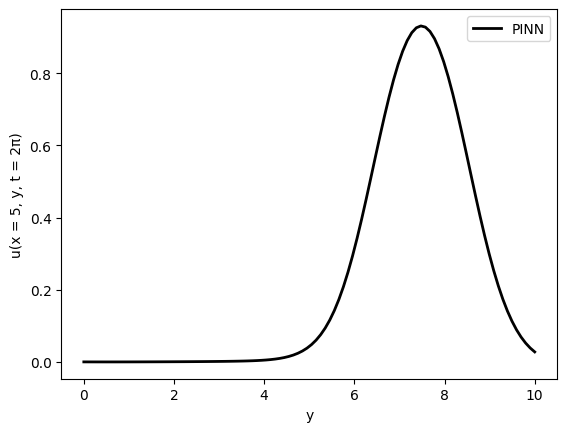

In [21]:
plt.plot(y, predicted_solution, color='k', linewidth=2, label='PINN')
plt.xlabel('y')
plt.ylabel('u(x = 5, y, t = 2π)')
plt.legend()
plt.show()